In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display

# Oefening: Data science bij Disney World
## Overzicht
In deze oefening bekijken we gegevens die wachttijdinformatie bevatten voor alle attracties in Disney World. We valideren eerst de gegeven gegevens en onderzoeken vervolgens een aantal specifieke business questions.

## Deel 1: Het opzetten van je werkruimte
Initialiseer een git-repository op je persoonlijke GitHub-account. Je moet de gegevens niet toevoegen aan deze git-repo (gebruik een .gitignore). Uiteindelijk moet je mij voorzien van een .yml-bestand waarmee ik een virtuele omgeving kan maken waarin ik al je code kan uitvoeren.

**Tip**: Je kan beginnen met werken in een basisomgeving en vervolgens aan het einde van het project een *.yml*-bestand maken. Ook de github pagina kan je op het einde aanmaken waarna je alles toevoegt.

## Deel 2: Inlezen en inspecteren
### Stap 1: De gegevens inlezen en samenvatten
Lees alle wachttijd-csv-bestanden in die zich bevinden in `data/waiting times`. Verzamel ze in één groot dataframe waarin je een extra kolom attractie toevoegt waarin je de naam van de attracties plaatst (die uit de bestandsnaam kunnen worden gehaald).

In [3]:
locs = {'waiting_folder' : '../data/waiting times'}

In [4]:
waiting_times = list()
for attraction in tqdm(os.listdir(locs['waiting_folder'])):
    filename = os.path.join(locs['waiting_folder'], attraction)
    df = pd.read_csv(filename)
    if df.empty:
        continue
    df.insert(0, 'attraction', attraction.split('.')[0])
    waiting_times.append(df)

df_wait_raw = pd.concat(waiting_times, ignore_index=True)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:07<00:00,  6.67it/s]


In [5]:
df_wait = df_wait_raw.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

Removed 1318703 rows


In [6]:
df_wait

,attraction,date,datetime,SACTMIN,SPOSTMIN
0,7_dwarfs_train,2015-01-01,2015-01-01 07:51:12,NaN,45.0
1,7_dwarfs_train,2015-01-01,2015-01-01 08:02:13,NaN,60.0
2,7_dwarfs_train,2015-01-01,2015-01-01 08:05:30,54.0,NaN
3,7_dwarfs_train,2015-01-01,2015-01-01 08:09:12,NaN,60.0
4,7_dwarfs_train,2015-01-01,2015-01-01 08:16:12,NaN,60.0
...,...,...,...,...,...
10306135,winnie_the_pooh,2021-12-28,2021-12-28 22:34:35,NaN,5.0
10306136,winnie_the_pooh,2021-12-28,2021-12-28 22:42:15,NaN,5.0
10306137,winnie_the_pooh,2021-12-28,2021-12-28 22:48:12,NaN,5.0
10306138,winnie_the_pooh,2021-12-28,2021-12-28 22:54:10,NaN,5.0


In [7]:
df_wait_post.groupby('attraction')['SPOSTMIN'].describe().head()

,count,mean,std,min,25%,50%,75%,max
attraction,,,,,,,,
7_dwarfs_train,290934.0,76.962455,33.993364,0.0,50.0,70.0,95.0,300.0
alien_saucers,121772.0,29.863351,15.998896,0.0,20.0,30.0,40.0,190.0
astro_orbiter,274923.0,27.026822,13.458805,0.0,20.0,25.0,35.0,180.0
barnstormer,286649.0,19.227069,14.330115,0.0,5.0,15.0,25.0,120.0
big_thunder_mtn,274544.0,37.630817,23.339693,0.0,20.0,35.0,50.0,300.0


In [8]:
df_wait_post.groupby('attraction')['SPOSTMIN'].describe().head()

,count,mean,std,min,25%,50%,75%,max
attraction,,,,,,,,
7_dwarfs_train,290934.0,76.962455,33.993364,0.0,50.0,70.0,95.0,300.0
alien_saucers,121772.0,29.863351,15.998896,0.0,20.0,30.0,40.0,190.0
astro_orbiter,274923.0,27.026822,13.458805,0.0,20.0,25.0,35.0,180.0
barnstormer,286649.0,19.227069,14.330115,0.0,5.0,15.0,25.0,120.0
big_thunder_mtn,274544.0,37.630817,23.339693,0.0,20.0,35.0,50.0,300.0


### Stap 2: Valideer de gegevens met behulp van enkele visuele voorstellingen
Maak een functie die het dataframe dat je zojuist hebt gemaakt, een datum en een lijst met attracties als invoer neemt. De functie moet vervolgens een plot maken waarin je de wachttijd over de gegeven datum hebt voor alle geselecteerde attracties. Je kunt deze functie gebruiken om een gevoel te krijgen voor hoe goed de werkelijke en geposte wachttijden zijn gevuld.

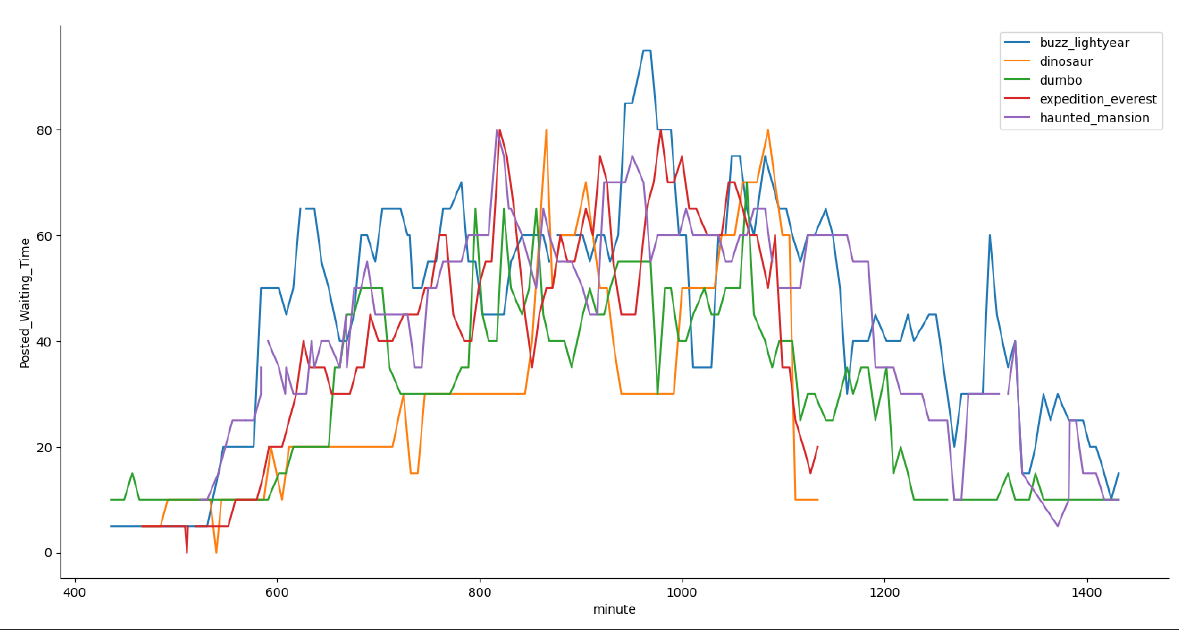

In [9]:
# Create a dropdown widget for selecting attractions
attraction_dropdown = widgets.Dropdown(
    options=attractions,
    description='Attraction:',
    value=attractions[0]  # Default value
)

# Function to update the plot based on selected attraction
def update_plot(attraction):
    plt.figure(figsize=(12, 4))  # Create a new figure
    plt.subplot(1, 2, 1)  # First subplot
    df_wait_attraction = df_wait.query("attraction == @attraction")
    df_wait_attraction.SACTMIN.plot.hist(bins=30, title='Actual waiting times')
    
    plt.subplot(1, 2, 2)  # Second subplot
    df_wait_attraction.SPOSTMIN.plot.hist(bins=np.arange(-2.5, df_wait.SPOSTMIN.max() + 2.5, 10), title='Posted waiting times')
    
    plt.tight_layout()

# Link the dropdown to the update function
interactive_plot = widgets.interactive(update_plot, attraction=attraction_dropdown)

# Display the interactive plot
display(interactive_plot)

interactive(children=(Dropdown(description='Attraction:', options=('7_dwarfs_train', 'alien_saucers', 'astro_o…

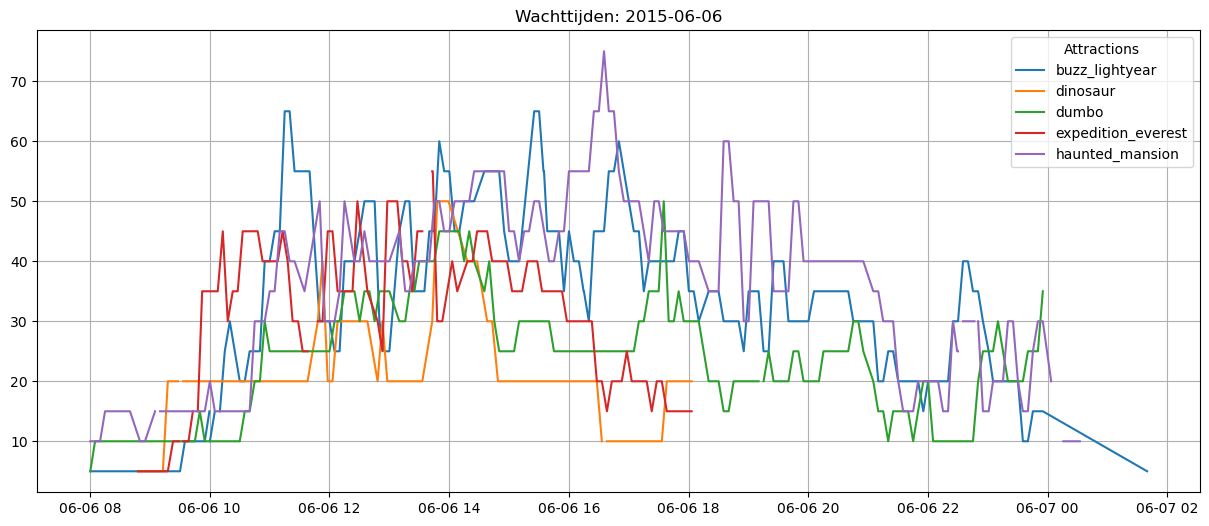

In [10]:
chosen_date = "2015-06-06" 
chosen_attractions = ["buzz_lightyear", "dinosaur", "dumbo", "expedition_everest", "haunted_mansion"]

df_chosen = df_wait[(df_wait["date"] == chosen_date) & (df_wait["attraction"].isin(chosen_attractions))]

plt.figure(figsize=(15, 6))

for i, attraction in enumerate(chosen_attractions):
        df_attractie = df_chosen[df_chosen["attraction"] == attraction]
        plt.plot(df_attractie["datetime"], df_attractie["SPOSTMIN"], label=f"{attraction}")

plt.title(f"Wachttijden: {chosen_date}")
plt.legend(title="Attractions")
plt.grid()

plt.show()

### Stap 3: Onderzoek voor welke attracties we voldoende informatie hebben over de geposte wachttijd.
Kijk naar hoeveel gegevenspunten van geposte wachttijd je per dag hebt voor elke attractie. Op deze manier kun je attracties uitsluiten met te weinig gegevenspunten gemiddeld.

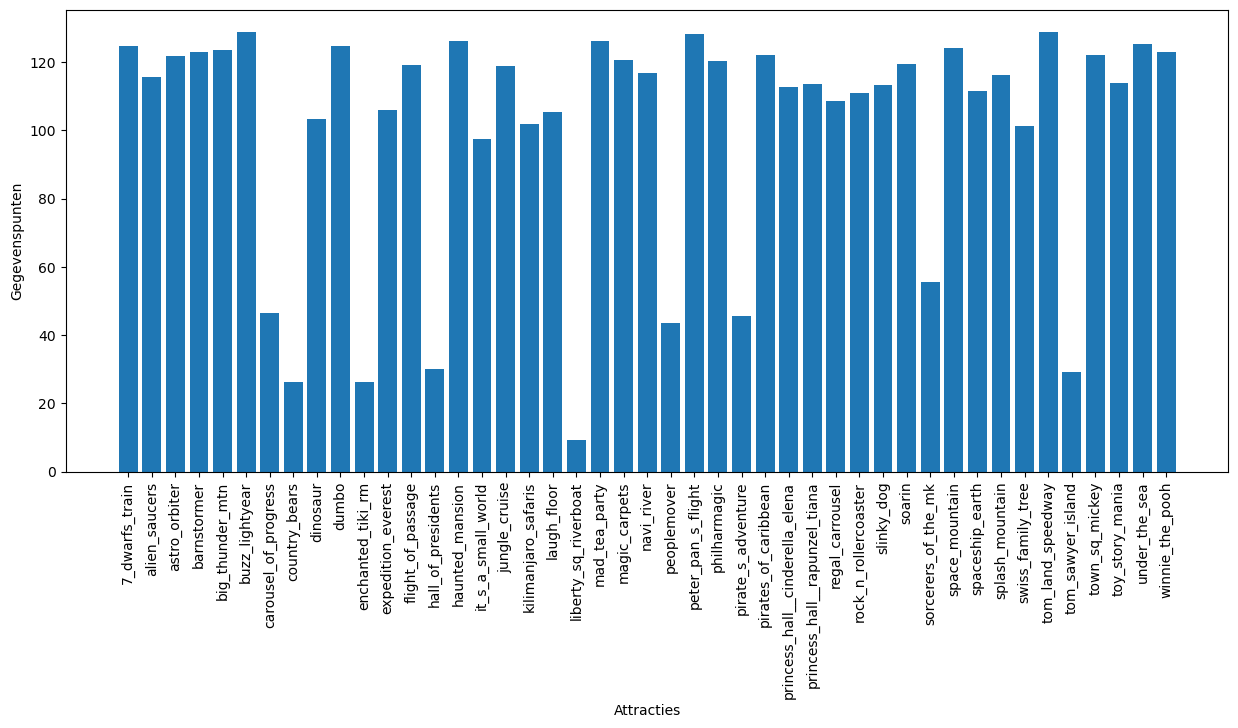

In [13]:
posted_count = df_wait.groupby(["attraction", "date"])["SPOSTMIN"].count().reset_index()

avg_posted_count = posted_count.groupby("attraction")["SPOSTMIN"].mean().reset_index()

plt.figure(figsize=(15, 6))
plt.bar(avg_posted_count["attraction"], avg_posted_count["SPOSTMIN"])

plt.xlabel("Attracties")
plt.ylabel("Gegevenspunten")
plt.xticks(rotation=90)

plt.show()


### Stap 4: Bestudeer de spreiding van de beschikbaarheid van gegevens voor actuele wachttijdinformatie.

Er lijkt niet zo veel informatie beschikbaar te zijn over de werkelijke wachttijden bij attracties. Is dit omdat we elke dag gewoon beperkte gegevens hebben, of zijn er enkele dagen met veel informatie? Maak een aantal
visualisaties maken om dit te onderzoeken?

## Onderzoeksvraag 1: Vergelijk voorspelde en werkelijke wachttijd
Maak een visualisatie die laat zien hoe de voorspelde en werkelijke wachttijden zich tot elkaar verhouden.

Hiervoor kan je volgende stappen uitvoeren:
 - Zoek voor elke werkelijke wachttijd de vorige en volgende voorspelde wachttijd.
 - Gebruik lineaire interpolatie om de beste schatting van de gepubliceerde wachttijd te vinden voor de werkelijke wachttijd die we onderzoeken.
 - Bereken het verschil tussen de werkelijke en de geposte wachttijd.
 - Maak een histogram van al deze verschillen, een scatterplot is hier ook een geschikte visualizatie.

Je kan ook eens kijken naar enkele specifieke datum & attractie combinaties waarvoor je veel werkelijke wachttijdinformatie hebt en dan de werkelijke en geposte wachttijd uittekenen en vergelijken.

## Onderzoeksvraag 2: beste dag voor attracties
Filter de attracties met `category_code == ride` uit en zoek uit welke dag van de week
(maandag/dinsdag/...) deze attracties gemiddeld de kortste wachttijden hebben. 

Probeer in een tweede stap verder specifiek te kijken naar de combinatie van dag van de week en `HOLIDAYM`-waarde. Idealiter zou je ook uitleggen wat dit betekent.